In [1]:
import os
import sys

sys.path.append(os.path.abspath("../../"))


import json

import numpy as np
import pandas as pd
from plotnine import (
    aes,
    geom_text,
    geom_tile,
    ggplot,
    scale_x_discrete,
    xlab,
    ylab,
)
from sklearn.metrics import confusion_matrix, f1_score


# Late Fusion (Summation)

In diesem Abschnitt werden die erzielten Ergebnisse und das Late-Fusion Modell weitergehend untersucht, um folgenden Forschungsfragen zu beantworten:
- Wie ist die performance auf IEMOCAP und MELD
- Gibt es Änderungen in der Klassifizierung im Vergleich zum normalen InstructERC
  - Wenn ja, welche?
- Was wird durch die Akustik erkannt?
  - Was wird nur durch Akustik erkannt?
  - Gibt es Verbesserungen in bestimmten Emotionen
- Kann das Modell das volle Potenzial aus beiden Modalitäten ausnutzen?
- Wie effektiv ist das Gate?
  - Ist ein Bias enthalten?
  - Wird es benötigt? 
    - Was passiert ohne Gate-training (gate = 0.5)?
    - Kann man einfach das Ergebis mit der höchstenSicherheit nehmen?
  - Was passiert bei verauschtem Audiosignal?
- Wie sieht der Latenzraum der beiden Modalitäten aus?

In [29]:
def sigmoid(x: float) -> float:
    return 1 / (1 + np.exp(-x))


def softmax(x: list[float]) -> list[float]:
    return np.exp(x) / np.sum(np.exp(x))


import re


def get_dialog(prompt: str) -> tuple[list[str], set[str]]:
    base_prompt = "Now you are expert of sentiment and emotional analysis. The following conversation noted between '### ###' involves several speaker."
    prompt = prompt.replace(base_prompt, "")
    dialouge = re.findall(r"###(.*)###", prompt)[0].strip()
    dialog_text = re.findall(
        r"Speaker_\d:\s?\"(.*?)(?=\"\s?\t|\"\s?$)", dialouge, re.MULTILINE
    )
    involved_speakers = set(re.findall(r"(Speaker_\d)", dialouge))
    return dialog_text, involved_speakers


def get_result_dataframe(base_path: str, dataset: str):
    text_only_p = os.path.join(base_path, dataset, "preds_test_no_audio.json")
    audio_only_p = os.path.join(base_path, dataset, "preds_test_no_text.json")
    both_p = os.path.join(base_path, dataset, "preds_test.json")

    with open(text_only_p, "rt") as f:
        text_only = json.load(f)

    with open(audio_only_p, "rt") as f:
        audio_only = json.load(f)

    with open(both_p, "rt") as f:
        both = json.load(f)

    results = (
        pd.DataFrame.from_records(text_only, index=["index"])
        .merge(
            pd.DataFrame.from_records(audio_only, index=["index", "input", "target"]),
            on=["index"],
            suffixes=["_text", "_audio"],
        )
        .merge(
            pd.DataFrame.from_records(both, index=["index", "input", "target"]),
            on=["index"],
            suffixes=["_both"],
        )
    )
    assert len(results) == len(text_only)
    results["utterance"] = results["input"].str.extract('<Speaker_\d: "(.*?)">')

    results["dialouge_length"] = results["input"].apply(lambda x: len(get_dialog(x)[0]))
    results["utterence_length"] = results["utterance"].apply(lambda x: len(x.split()))

    results["gates"] = results["gates"].apply(lambda x: softmax(x))
    results["text_gate"] = results["gates"].apply(lambda x: x[0])
    results["audio_gate"] = results["gates"].apply(lambda x: x[1])
    results = results.drop(["gates_text", "gates_audio"], axis=1)

    return results


def get_instructerc_results(base_path: str, dataset: str):
    path = os.path.join(base_path, dataset, "preds_for_eval.txt")
    with open(path, "rt") as f:
        for _ in range(15):  # Skip the first 16 lines
            next(f)
        json_data = f.read()
        data = json.loads(json_data)

    results = pd.DataFrame.from_records(data, index=["index"])
    results["utterance"] = results["input"].str.extract('<Speaker_\d: "(.*?)">')

    results["dialouge_length"] = results["input"].apply(lambda x: len(get_dialog(x)[0]))
    results["utterence_length"] = results["utterance"].apply(lambda x: len(x.split()))

    return results

ierc_iemocap = get_instructerc_results("./results/InstructERC", "IEMOCAP")
ierc_iemocap.head()

,input,output,target,utterance,dialouge_length,utterence_length
index,,,,,,
0,Now you are expert of sentiment and emotional ...,happy,happy,[LAUGHTER],13,1
1,Now you are expert of sentiment and emotional ...,angry,angry,I hate you.,13,3
2,Now you are expert of sentiment and emotional ...,neutral,angry,They're away in Tunis.,13,4
3,Now you are expert of sentiment and emotional ...,neutral,neutral,"Well, you know what, does your D.S.L. cable --...",13,13
4,Now you are expert of sentiment and emotional ...,sad,happy,"Like Larry's brother. Do it like you, Chris. ...",13,12


In [30]:

base_path = "./results/late_fusion/IEMOCAP/loss_gate"

results = get_result_dataframe(base_path, "")
# results = results.merge(ierc_iemocap, on=["utterance"])
results.head()

,input,output_text,target,certainty_text,output_audio,certainty_audio,output,certainty,gates,utterance,dialouge_length,utterence_length,text_gate,audio_gate
index,,,,,,,,,,,,,,
0,Now you are expert of sentiment and emotional ...,frustrated,neutral,0.470215,neutral,0.562012,neutral,0.574219,"[0.6709317724913618, 0.3290682275086381]","Hi, I need an ID.",1,5,0.670932,0.329068
1,Now you are expert of sentiment and emotional ...,neutral,neutral,0.842773,neutral,0.504395,neutral,0.832031,"[0.7500496213021285, 0.24995037869787143]","ahh Yeah, this is the wrong line. I'm sorry. ...",2,26,0.750050,0.249950
2,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.872559,neutral,0.477539,frustrated,0.719238,"[0.8437020324411578, 0.15629796755884215]","Okay, I'm sorry, but I just stood in this line...",3,21,0.843702,0.156298
3,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.890625,neutral,0.412842,frustrated,0.835449,"[0.8249912935785234, 0.17500870642147665]","No, they told me-I'm sorry, but they told me t...",5,14,0.824991,0.175009
4,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.898926,neutral,0.608887,frustrated,0.828125,"[0.8196047411357772, 0.18039525886422272]","What, I mean what... what's the difference? W...",7,19,0.819605,0.180395


## Wie ist die Differenz zwischen text-/audio-only in der Klassifizierung?

In [3]:
text_only_correct = results[(results["output_text"] == results["target"]) & (results["output_audio"] != results["target"])]
audio_only_correct = results[(results["output_text"] != results["target"]) & (results["output_audio"] == results["target"])]
both_only_correct = results[(results["output"] == results["target"]) & (results["output_audio"] != results["target"]) & (results["output_text"] != results["target"])]
text_correct_but_not_both = results[(results["output_text"] == results["target"]) & (results["output"] != results["target"])]
audio_correct_but_not_both = results[(results["output_audio"] == results["target"]) & (results["output"] != results["target"])]
text_correct_but_not_audio_and_both = results[(results["output_text"] == results["target"]) & (results["output_audio"] != results["target"]) & (results["output"] != results["target"])]
audio_correct_but_not_text_and_both = results[(results["output_text"] != results["target"]) & (results["output_audio"] == results["target"]) & (results["output"] != results["target"])]

print(f"es konnten {len(text_only_correct)} Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only")
print(f"es konnten {len(audio_only_correct)} Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only")
print(f"es konnten {len(both_only_correct)} Datenpunkte nur durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(text_correct_but_not_both)} Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(audio_correct_but_not_both)} Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(text_correct_but_not_audio_and_both)} Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(audio_correct_but_not_text_and_both)} Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input erkannt werden")


es konnten 486 Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only
es konnten 175 Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only
es konnten 39 Datenpunkte nur durch gemeinsamen Input erkannt werden
es konnten 65 Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden
es konnten 112 Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden
es konnten 61 Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input erkannt werden
es konnten 108 Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input erkannt werden


Daraus lässt sich in Bezug auf die zusätzliche Modalität folgern:
- Audio-Input darf nicht vernachlässigt werden, da 175 Beispiele nur von der Akustik korrekt klassifiziert werden konnte, nicht aber vom Text
- Audio wird aber stark unterdrückt. von den 175, die nur von der Akustik erkannt werden konnten, werden 112 weiterhin nicht erkannt, wenn der Text hinzukommt.

## Wie verhält sich der Gating-Mechanismus?

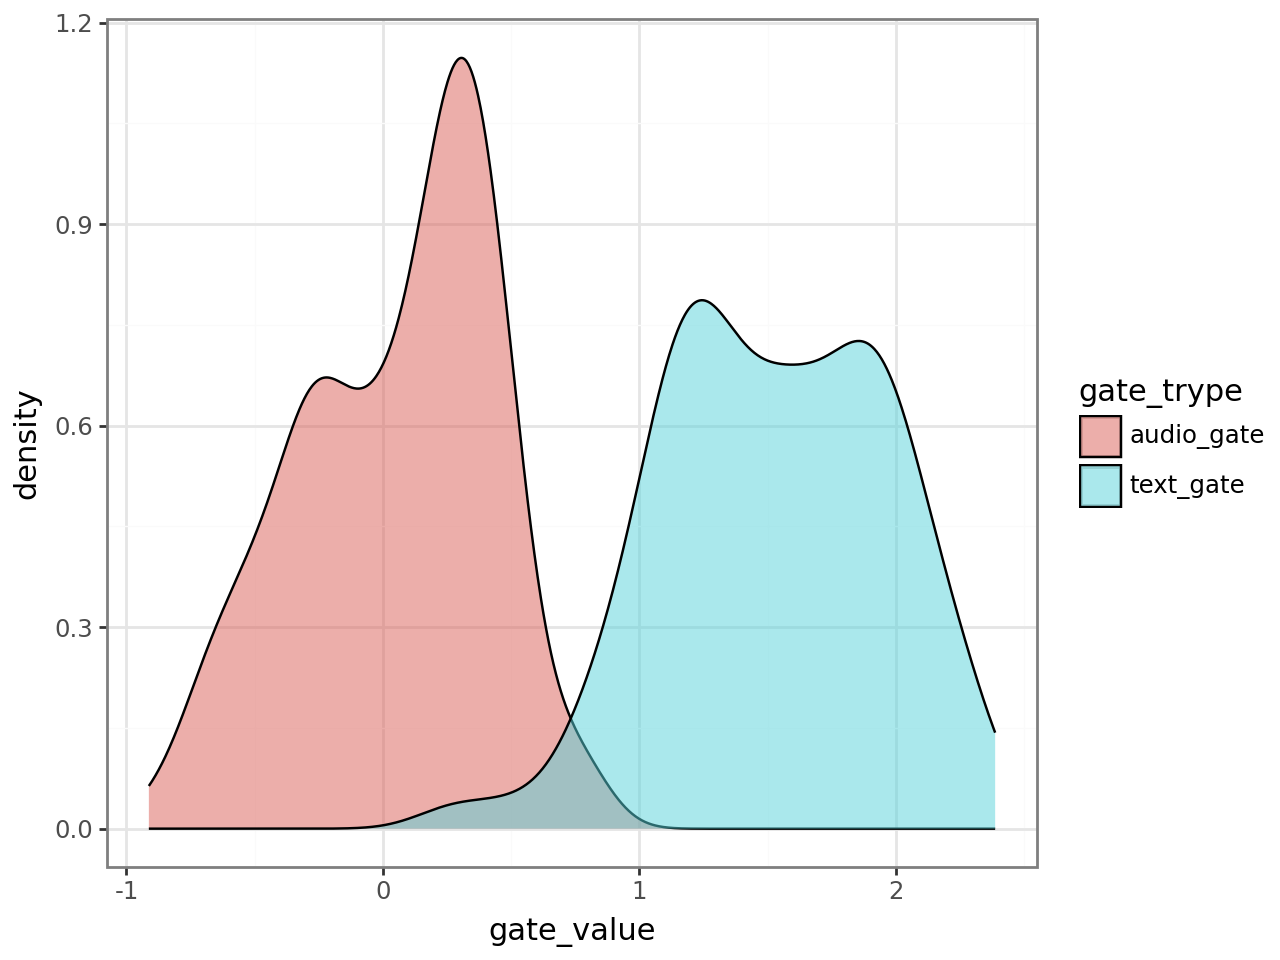

In [12]:
from plotnine import geom_density, geom_histogram, theme_bw

(
    ggplot(audio_only_correct.melt(value_vars=["text_gate", "audio_gate"], var_name="gate_trype", value_name="gate_value"), aes(x="gate_value", fill="gate_trype")) +
    geom_density(alpha=0.5) +
    # geom_histogram(binwidth=0.1, alpha=0.5, position="identity") +
    # xlim(0, 1) + 
    theme_bw()
)

## Idealer F1 Score
Dafür wird der F1 Score zwischen der Verknüpfung $(y_t = y) \vee (y_a = y) \vee (y_b = y)$ und $y$ berechnet.
Für die übrig bleibenden / überall falschen Felder, wird das Ergebnis vom gemischten Modell eingetragen. Dies hat aber keinen Einfluss auf den F1 Score

In [5]:
results["any_correct"] = results[(results["output_text"] == results["target"]) | (results["output_audio"] == results["target"]) | (results["output"] == results["target"])]["target"]
results.loc[results["any_correct"].isna(), "any_correct"] = results.loc[results["any_correct"].isna(), "output"]

f1 = f1_score(results["target"], results["output"], average="weighted")
ideal_f1 = f1_score(results["target"], results["any_correct"], average="weighted")

print(f"Model F1 Score: {f1:.3f}")
print(f"Idealer F1 Score: {ideal_f1:.3f}")

Model F1 Score: 0.715
Idealer F1 Score: 0.821


Wäre das Modell in der Lage die Teilmodelle (Akustik- und Sprachmodell) perfekt einzusetzen, wäre ein theoretischer F1-Score von 0.808 möglich, angenommen keine weiteren Beispiele lassen sich nur durch gemeinsamen Input klassifizieren.

## Confusion Matrix

In [6]:
from plotnine import scale_color_manual, scale_fill_cmap

target_labels = results["target"].value_counts().index.to_list()[::-1]


def print_confusion_matrix(
    results: pd.DataFrame,
    target_labels: list[str] | None = None,
    output_column: str = "output",
) -> None:
    target_labels = (
        results["target"].unique() if target_labels is None else target_labels
    )
    cm = confusion_matrix(results["target"], results[output_column], labels=target_labels)
    cm_df = pd.DataFrame(cm, index=target_labels, columns=target_labels)
    cm_melted = cm_df.reset_index().melt(id_vars="index", value_name="count")
    cm_melted.columns = ["actual", "predicted", "count"]
    cm_melted["actual"] = pd.Categorical(cm_melted["actual"], categories=target_labels)
    cm_melted["predicted"] = pd.Categorical(
        cm_melted["predicted"], categories=target_labels
    )

    # Calculate total counts for each actual class
    total_counts = cm_melted.groupby("actual")["count"].sum().reset_index()
    total_counts.columns = ["actual", "total_count"]

    # Merge total counts back to the melted DataFrame
    cm_melted = cm_melted.merge(total_counts, on="actual")

    # Calculate the fraction
    cm_melted["sqrt_fraction"] = np.sqrt(cm_melted["count"]) / np.sqrt(cm_melted["total_count"])
    cm_melted["fraction"] = (cm_melted["count"] / cm_melted["total_count"]).round(2)
    cm_melted["label"] = cm_melted["count"].astype(str) + " (" + cm_melted["fraction"].astype(str) + ")"
    cm_melted["p_group"] = cm_melted["fraction"].apply(lambda x: "high" if x > 0.5 else "low")

    p = (
        ggplot(cm_melted, aes("factor(predicted)", "factor(actual)", fill="sqrt_fraction"))
        + geom_tile(show_legend=False)
        + geom_text(aes(label="label", color="p_group"), size=8, show_legend=False)
        + ylab("Predicted")
        + xlab("True")
        + scale_x_discrete(limits=target_labels[::-1])
        + scale_fill_cmap(cmap_name="magma")
        + scale_color_manual(["black", "white"])
    )

    p.show()

Die Confusion Matrix enthät neben der absoluten Anzahl auch das Verhältnis in der entsprechenden Reihe

**Confusion Matrix vom text-only Modell**

C:\Users\hfock\AppData\Local\Temp\ipykernel_22128\402107308.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


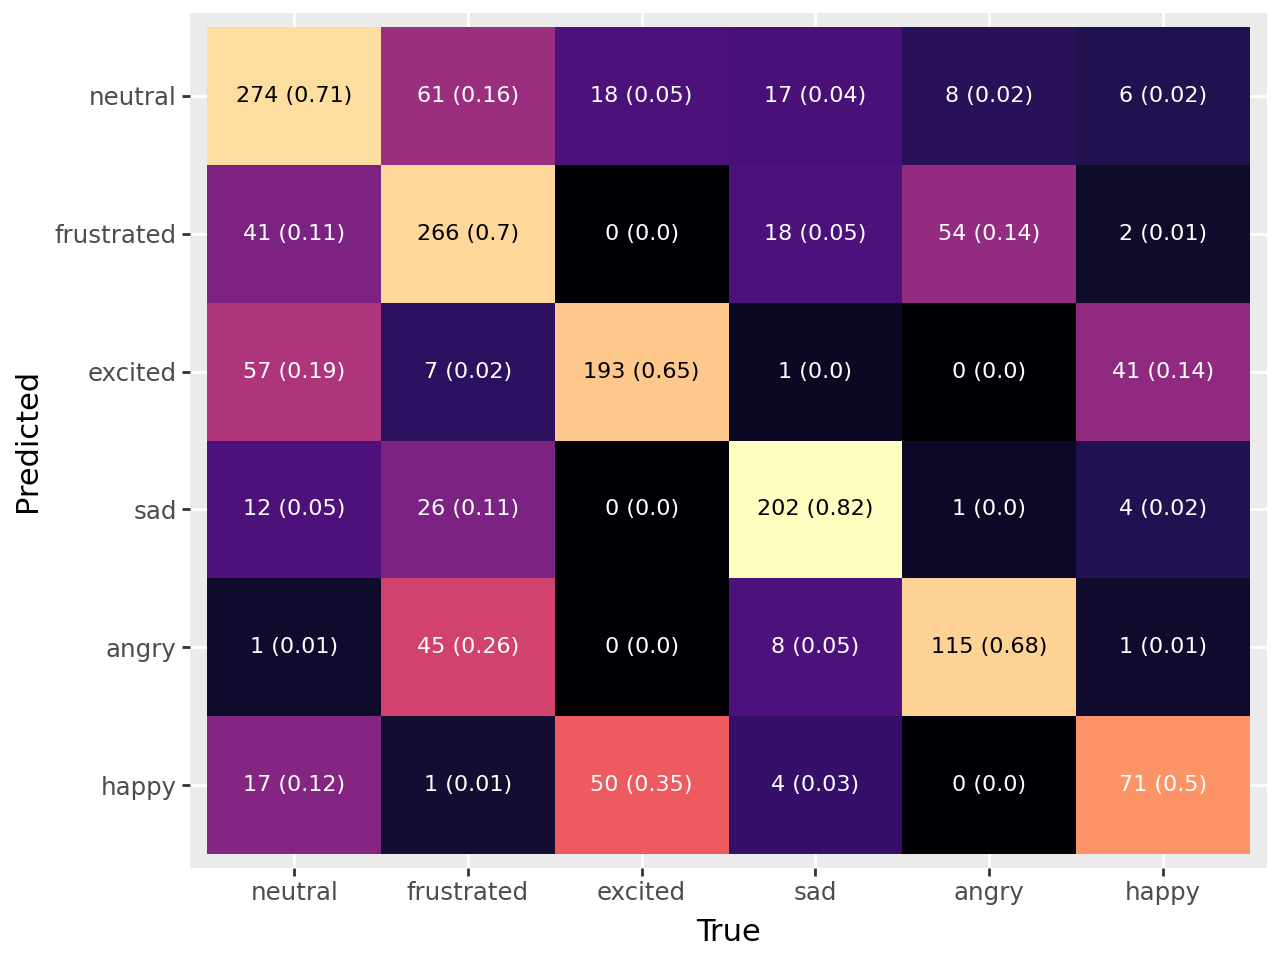

In [7]:
print_confusion_matrix(results, target_labels, output_column="output_text")

- Die meisten verwechselungen gibt es mit "neutral"
- Nah beieinander liegende Emotionen werden oft verwechselt
  - "excited" mit "happy"
  - "angry" mit "frustrated"

**Confisuin Matrix vom audio-only Modell**

C:\Users\hfock\AppData\Local\Temp\ipykernel_22128\402107308.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


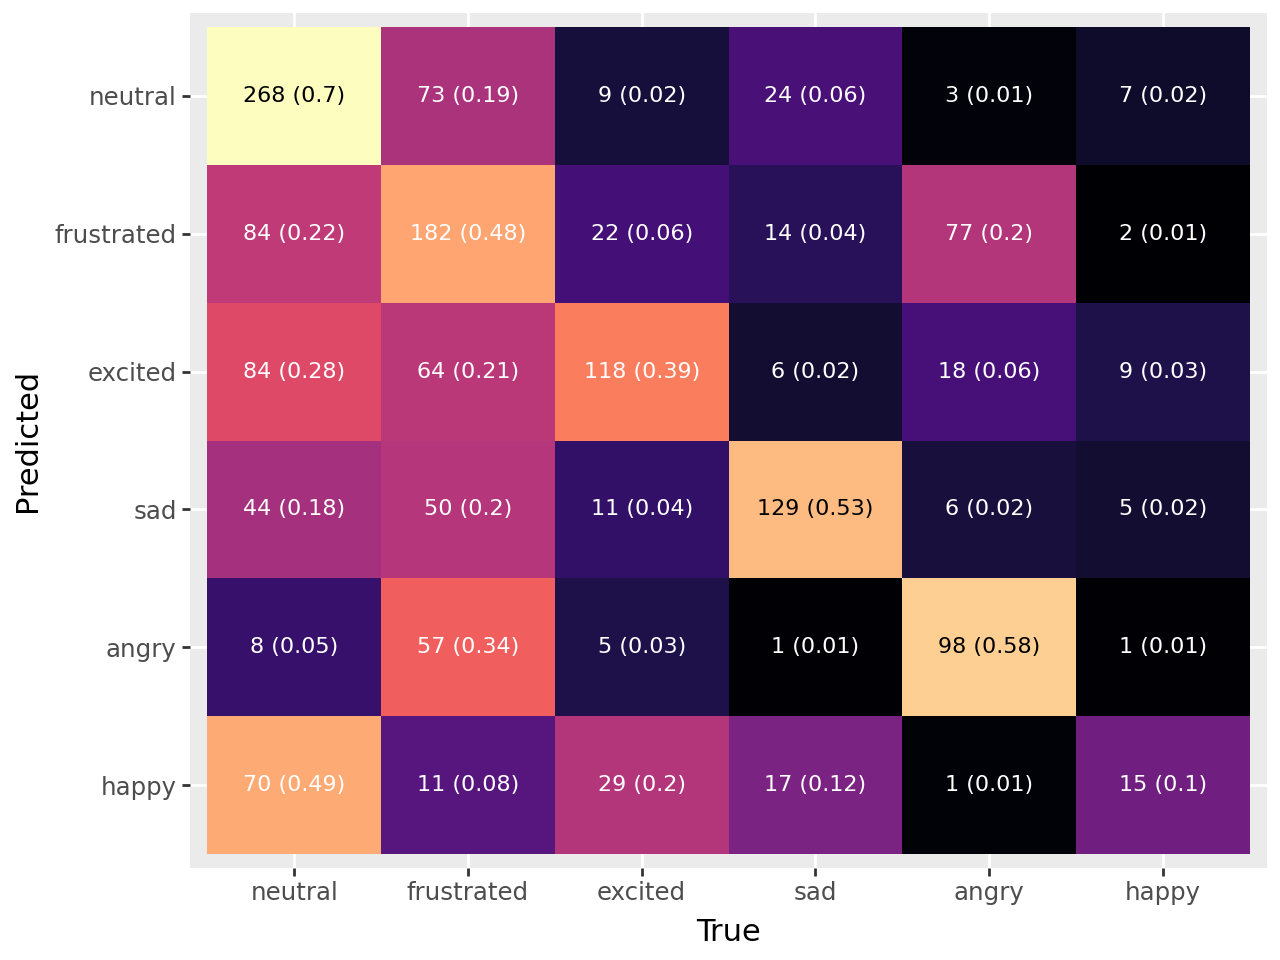

In [8]:
print_confusion_matrix(results, target_labels, output_column="output_audio")

Hier stellt sich ein ähnliches Bild, wie beim text ein, nur, dass die Werte stärker verteilt sind (niedrigerer F1)

**Confusion Matrix vom kombinierten Modell**

C:\Users\hfock\AppData\Local\Temp\ipykernel_22128\402107308.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


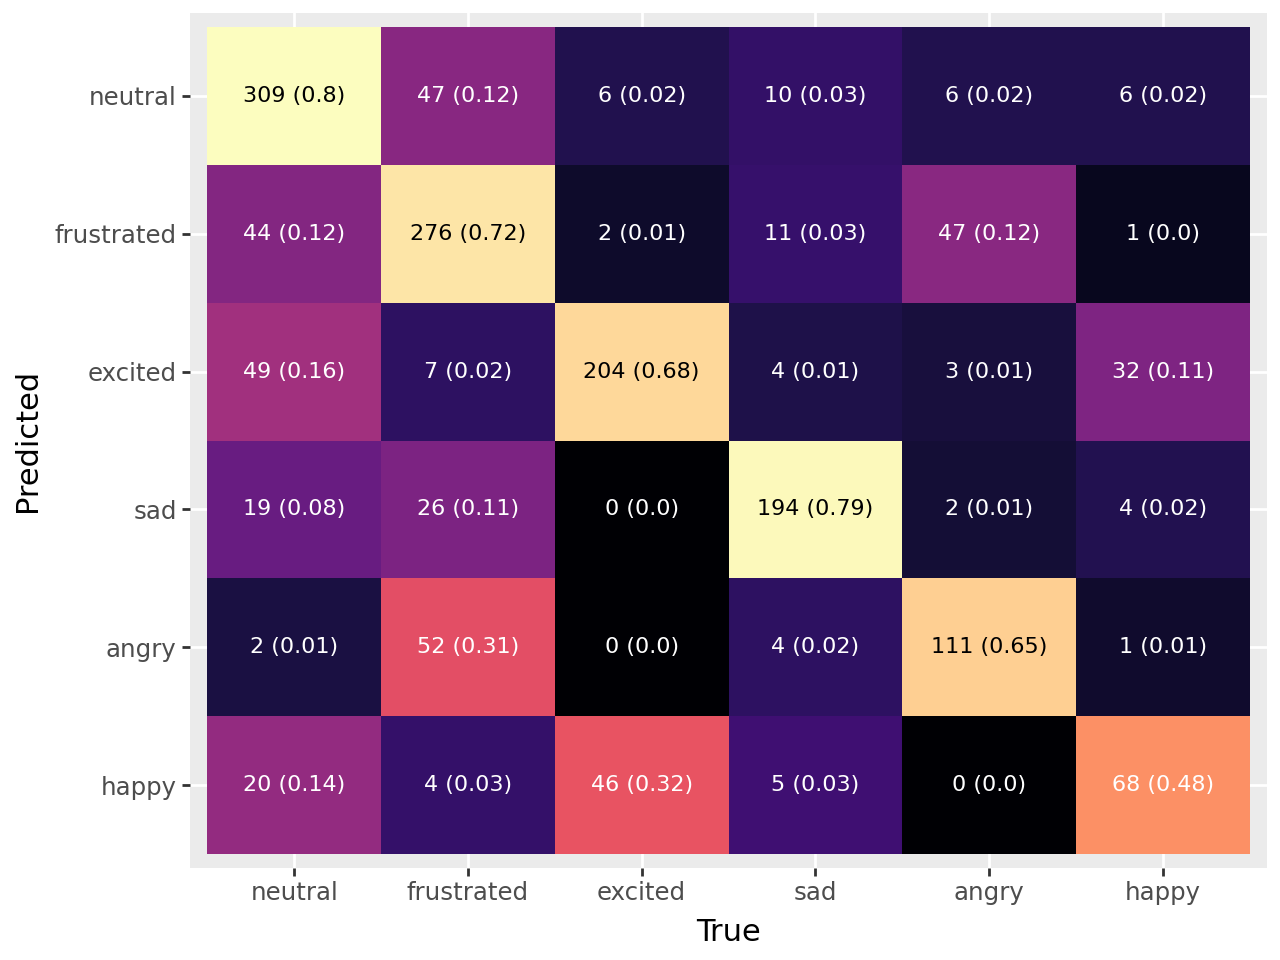

In [9]:
print_confusion_matrix(results, target_labels, output_column="output")